In [42]:
%load_ext autoreload
%autoreload 2

from scipy.signal import blackmanharris, gaussian
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from phase_transform import PhaseTransform
from pathlib import Path
import keras.backend as K
import keras
from keras.layers import Dense, Concatenate, Lambda
from keras.layers import Input, Reshape, Flatten
from keras.layers import BatchNormalization as BN
from keras.models import Model
from keras.initializers import Orthogonal
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti
import numpy as np
from utils import *


sample_rate = 44100
nfft = 4096
freq_bins = nfft//2+1
time_context = 11
num_epochs = 10
batch_size = 16

tt = PhaseTransform(frameSize=nfft, hopSize=nfft//4, sampleRate=sample_rate, window=blackmanharris)

features_path = "/media/pierre-louis/TOSHIBA EXT/.pierre-louis/results/features/"
# features_path = Path("./results/features/")
traingen = DataGenerator(features_path + "train", freq_bins=freq_bins, batch_size=batch_size)
validgen = DataGenerator(features_path + "valid", freq_bins=freq_bins, batch_size=batch_size)

sources = ['vocals','bass','drums','other']
n_sources = len(sources)
channels = ['left', 'right']
n_channels = len(channels)



model_dir = "results/models"
os.makedirs(model_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
417
8


# Visualizing the data
it would be good to reduce to float32 for increasing RAM on RTX 2070

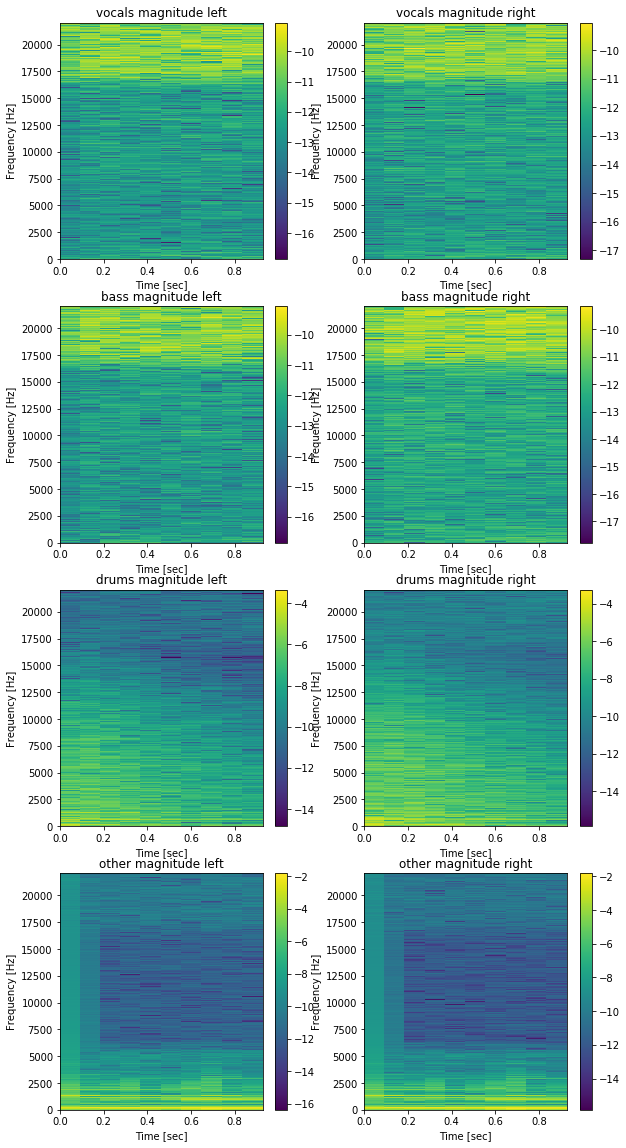

In [34]:
inputs, outputs = traingen[0]
assert inputs['amplitude'].shape[0] == batch_size
assert inputs['amplitude'].shape[1] == n_channels
assert inputs['amplitude'].shape[2] == time_context
assert inputs['amplitude'].shape[3] == freq_bins

targets = traingen.target
f = np.arange(freq_bins)*sample_rate/nfft
t = np.arange(time_context, dtype=float)/sample_rate*nfft

plt.figure(figsize=(5*n_channels,5*n_sources))
for i, source in enumerate(sources):
    for j, channel in enumerate(channels):
        plt.subplot(n_sources, n_channels, 1+n_channels*i+j)
        logmag = np.log(1e-8+targets[0,n_channels*i+j]).T
        plt.pcolormesh(t[:time_context,], f[:,], logmag[:,:time_context])
        plt.colorbar()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(source + " magnitude " + channel)
plt.show()

# Training

In [ ]:
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti

histories = []

for i, source in enumerate(sources):
    print("Training the", source)
    model = build_dnn(freq_bins=freq_bins)
    traingen.source_id = i
    validgen.source_id = i
    history = model.fit_generator(traingen, validation_data=validgen, verbose=True,
               epochs=10, use_multiprocessing=True, workers=3)
    
    model.save(source + ".h5")
    del model
    histories.append(history)
    plot_history(history)
    


Training the vocals
Epoch 1/10
417/417 [==============================] - 44s 105ms/step - loss: 0.5675 - mean_absolute_error: 0.2007 - mean_squared_error: 0.5675 - val_loss: 0.1111 - val_mean_absolute_error: 0.1352 - val_mean_squared_error: 0.1111
Epoch 2/10
180/417 [===========>..................] - ETA: 16s - loss: 0.2504 - mean_absolute_error: 0.1213 - mean_squared_error: 0.2504

In [4]:
import pickle
with open("histories.pkl", "wb") as pkl:
    pickle.dump(histories, pkl)

In [ ]:
import pickle
with open("histories.pkl", "rb") as pkl:
    histories = pickle.load(pkl)

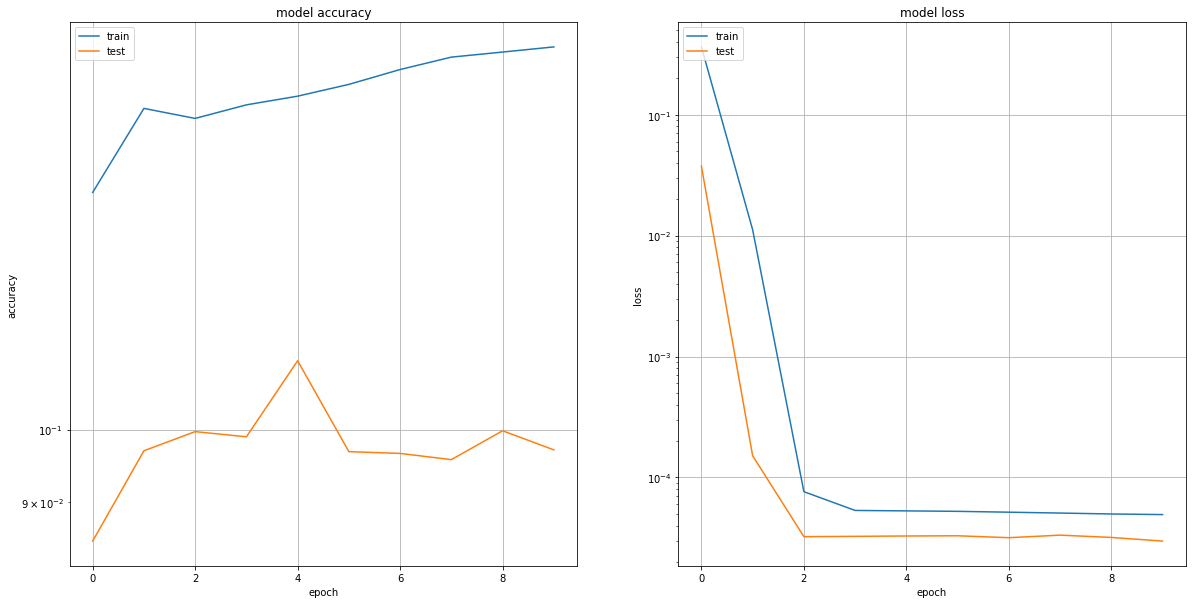

In [4]:
from utils import plot_history
import matplotlib.pyplot as plt
plot_history(histories[0])
plt.show()